# Crypto Image Learning, On the Fly

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
import sys
sys.path.append('/home/xbno/ml/finviz_scrape/plot')

In [4]:
from fastai.data_block import *
from data_utils import StockData, LabelStockData, PlotStockData, TransformPlot
#from model_utils import get_plot_batch_transforms

In [5]:
from model_utils import StockSigList

## Bis and asks

In [801]:
from stockstats import StockDataFrame
from datetime import datetime, timedelta
from dateutil import tz
import pandas as pd
import json
import urllib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from functools import partial
from io import BytesIO
import PIL

class StockData(object):
    def __init__(self,currency_pair,days,bar,load_path=None):
        """Get Poloniex Data
        No api_key required for publix api which gives back 15 min bars
        source: https://docs.poloniex.com/#returnchartdata
        """
        self.bar = bar
        self.load_path = load_path
        self.period = {'5m':'300','15m':'900','30m':'1800','2h':'7200','4h':'14400','24h':'86400'}
        self.days = days # duration of data
        self.currency_pair = currency_pair # what to grab
        self.utc_format = '%s'
        self.datetime_format = "%Y-%m-%dT%H:%M:%S"
        self.start = (datetime.utcnow()+timedelta(days=-self.days)).strftime(self.utc_format)
        self.end = (datetime.utcnow()).strftime(self.utc_format)
        self.poloniex_getChartData = f"https://poloniex.com/public?command=returnChartData&currencyPair={self.currency_pair}&start={self.start}&end={self.end}&period={self.period[self.bar]}"
        
        # setup
        if load_path:
            self.load_data()
            self.df_info()
            self.stockstats()
        else:
            self.get_data()
            self.df_info()
            self.stockstats()
        
    def get_data(self):
        df = pd.DataFrame(json.loads(urllib.request.urlopen(self.poloniex_getChartData).read()))
        df['date'] = df['date'].apply(self.unix2utc)
        df['date'] = df['date'].apply(self.utc2est)
        df['date'] = pd.to_datetime(df['date'])
        self.df = df

    # TODO 9 create function to load data
    def load_data(self):
        "Load from path"
        df = pd.read_csv(f'{self.load_path}/raw.csv')

    # TODO 9 create function to combine data
    def combine_data(self):
        "Query data up to current time, add it to presaved data"
        pass

    def trim(self):
        "Trim df to remove first bar and dropna"
        self.df = self.df.iloc[1:]
        self.df = self.df.dropna()
        self.df_info()
        
    def stockstats(self):
        """Convert to stockstats df
        https://github.com/jealous/stockstats
        """
        from stockstats import StockDataFrame
        self.df = StockDataFrame.retype(self.df)
        
    def df_info(self):
        "Print helpful info"
        print(f"dur: {self.days} day(s)")
        print(f"bars: {self.df.shape[0]}")
        if 'date' in self.df.columns:
            print(f"min: {self.df['date'].min()} EST") 
            print(f"max: {self.df['date'].max()} EST")
        else:
            print(f"min: {self.df.index.min()} EST") 
            print(f"max: {self.df.index.max()} EST")
                  
    def unix2utc(self,date):
        "Apply date column conversion from unix to utc"
        return datetime.utcfromtimestamp(date).strftime(self.datetime_format)
                  
    def utc2est(self,date):
        "Apply date column conversion from utc to est"
        from_zone = tz.gettz('UTC')
        to_zone = tz.gettz('America/New_York')
        date = datetime.strptime(date,self.datetime_format)
        date = date.replace(tzinfo=from_zone)
        return date.astimezone(to_zone).strftime(self.datetime_format)

In [805]:
data = StockData('USDT_ETH',5,'4h')

dur: 5 day(s)
bars: 30
min: 2019-05-16 03:52:25 EST
max: 2019-05-20 20:00:00 EST


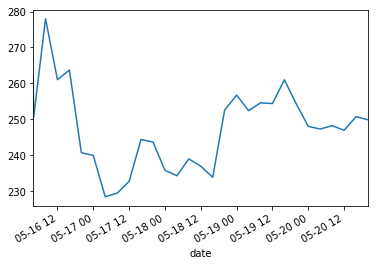

In [808]:
data.df['close'].plot()

In [774]:
from datetime import datetime, timedelta
import urllib

class StockData(object):
    def __init__(self,currency_pair,days,bar,depth,load_path=None):
        """Get Poloniex Data
        No api_key required for publix api which gives back 15 min bars
        source: https://docs.poloniex.com/#returnchartdata
        """
        self.bar = bar
        self.period = {'5m':'300','15m':'900','30m':'1800','2h':'7200','4h':'14400','24h':'86400'}
        self.days = days # duration of data
        self.currency_pair = currency_pair # what to grab
        self.utc_format = '%s'
        self.datetime_format = "%Y-%m-%dT%H:%M:%S"
        self.start = (datetime.utcnow()+timedelta(days=-self.days)).strftime(self.utc_format)
        self.end = (datetime.utcnow()).strftime(self.utc_format)
        self.poloniex_getChartData = f"https://poloniex.com/public?command=returnChartData&currencyPair={self.currency_pair}&start={self.start}&end={self.end}&period={self.period[self.bar]}"
        
        self.ob_depth = depth
        self.poloniex_returnOrderBook = f"https://poloniex.com/public?command=returnOrderBook&currencyPair={self.currency_pair}&depth={self.ob_depth}"
        
        self.poloniex_returnTradeHistory = f"https://poloniex.com/public?command=returnTradeHistory&currencyPair={self.currency_pair}&start={self.start}&end={self.end}"
        # setup
#         self.get_order_book()
#         self.df_info()

    def get_trade_hx(self):
        "Up to 50k"
        self.trade_hx = json.loads(urllib.request.urlopen(self.poloniex_returnTradeHistory).read())

    def get_order_book(self):
        "Only top 100"
        self.ob = json.loads(urllib.request.urlopen(self.poloniex_returnOrderBook).read())
#         df = pd.DataFrame(json.loads(urllib.request.urlopen(self.poloniex_returnOrderBook).read()))
#         df['date'] = df['date'].apply(self.unix2utc)
#         df['date'] = df['date'].apply(self.utc2est)
#         df['date'] = pd.to_datetime(df['date'])
#         self.df = df

In [791]:
ob = StockData('USDT_ETH',1,'15m',100)

In [792]:
ob.get_trade_hx()

In [793]:
len(ob.trade_hx)

1000

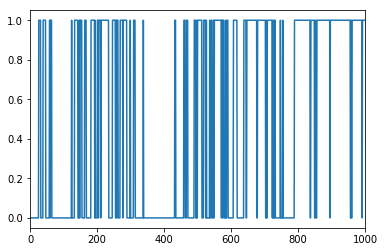

In [796]:
pd.DataFrame(ob.trade_hx)['type'].map({'buy':1,'sell':0}).plot()

In [723]:
asks2 = pd.DataFrame(ob.ob)

In [727]:
pd.DataFrame(ob.ob['asks'])

0     object
1    float64
dtype: object

In [754]:
asks = pd.DataFrame(ob.ob)

In [755]:
def split_price(row):
    return row[0]

def split_qnt(row):
    return row[1]

In [756]:
asks['ask_price'] = asks['asks'].apply(split_price)
asks['ask_qnt'] = asks['asks'].apply(split_qnt)
asks['bid_price'] = asks['bids'].apply(split_price)
asks['bid_qnt'] = asks['bids'].apply(split_qnt)
asks.drop(['asks','bids'],axis=1,inplace=True)

In [762]:
for col in asks.columns:
    asks[col] = pd.to_numeric(asks[col])

In [763]:
asks.groupby(['ask_price'])['ask_qnt'].sum().shape

(100,)

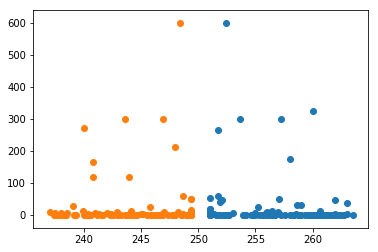

In [766]:
plt.scatter(asks['ask_price'],asks['ask_qnt'])
plt.scatter(asks['bid_price'],asks['bid_qnt'])

In [ ]:
asks

In [709]:
(asks[0]*asks[1]).sum()

654570.5785975077

In [ ]:
curl "https://poloniex.com/public?command=returnOrderBook&currencyPair=USDT_ETH&depth=10"

In [810]:
plot.df.iloc[0]

date                                                      2018-11-22 02:30:00
close                                                                 136.968
high                                                                  136.968
low                                                                    136.55
open                                                                   136.55
quotevolume                                                           3.48107
volume                                                                 475.75
weightedaverage                                                       136.668
15m_pct_change                                                     -0.0275758
30m_pct_change                                                    -1.4602e-08
45m_pct_change                                                      -0.158994
60m_pct_change                                                      -0.557774
75m_pct_change                                                  

In [811]:
plot.df.iloc[-1]

date                                                      2019-05-20 19:00:00
close                                                                 249.693
high                                                                  249.693
low                                                                   249.202
open                                                                  249.202
quotevolume                                                           12.1715
volume                                                                3036.59
weightedaverage                                                       249.485
15m_pct_change                                                       0.259242
30m_pct_change                                                        1.02068
45m_pct_change                                                       0.459488
60m_pct_change                                                       0.700173
75m_pct_change                                                  

In [812]:
plot.set_wdf()

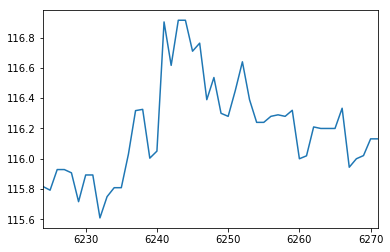

In [815]:
plot.wdf['close'].plot()

In [817]:
plot.path = '/Users/xbno/ML/finviz_scrape/plot/180days'

In [853]:
plot.df.tail(6)

,date,close,high,low,open,quotevolume,volume,weightedaverage,15m_pct_change,30m_pct_change,...,close_13_sma,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,tr,atr,image
17242,2019-05-20 17:45:00,252.184921,253.235611,251.000000,253.235611,13.684228,3440.379639,251.412048,-0.067974,0.045633,...,249.866135,252.469696,-0.284782,1.591013,61.405060,1.704485,63.024376,2.235617,2.100398,2019-05-20T17-45-00_usdt_eth.jpeg
17243,2019-05-20 18:00:00,252.599533,252.933441,251.639999,252.013504,30.817457,7771.337402,252.173218,-0.118578,-0.537376,...,250.440018,252.184921,0.414608,1.789912,64.156570,1.803628,64.331924,1.293435,2.042758,2019-05-20T18-00-00_usdt_eth.jpeg
17244,2019-05-20 18:15:00,251.494797,252.300003,250.355072,252.300003,16.849651,4244.475098,251.902847,-0.100472,-0.919128,...,250.816544,252.599533,-1.104727,1.094105,52.246891,1.400133,58.335640,2.244447,2.057164,2019-05-20T18-15-00_usdt_eth.jpeg
17245,2019-05-20 18:30:00,249.056610,251.474564,249.056610,251.242126,838.241089,210010.890625,250.537567,0.050846,0.058254,...,250.978439,251.494797,-2.438196,0.539084,35.026299,0.909985,47.643559,2.438196,2.084381,2019-05-20T18-30-00_usdt_eth.jpeg
17246,2019-05-20 18:45:00,248.216660,249.936539,248.216660,249.183243,38.458942,9588.296875,249.312531,0.396840,0.855435,...,251.068176,249.056610,-0.839937,0.445633,30.826138,0.804186,44.573334,1.719868,2.058344,2019-05-20T18-45-00_usdt_eth.jpeg
17247,2019-05-20 19:00:00,249.692688,249.692688,249.201691,249.201691,12.171453,3036.589355,249.484543,0.259242,1.020676,...,251.283768,248.216660,1.476024,0.811192,44.787743,1.027072,50.667751,1.476024,2.016750,2019-05-20T19-00-00_usdt_eth.jpeg


In [824]:
plot.df.head(10)[['open','close']]

,open,close
1,136.549896,136.967773
2,136.929993,136.967773
3,136.967773,136.750000
4,136.750000,136.143799
5,136.203796,136.949997
6,136.614456,137.099899
7,136.412338,136.550003
8,136.130188,135.059998
9,135.100006,135.239334
10,134.740005,133.839996


In [828]:
(136.967773-136.549896)/136.549896*100

0.3060251323809169

In [840]:
def pct_change(row):
    "Apply % change between bars"
    change = row['close'] - row['next_close']
    pct_inc = (change / row['next_close']) * 100
    return pct_inc

In [836]:
next_close_df = pd.concat([plot.df['close'],plot.df['close'].shift(-1)],axis=1)
next_close_df.columns = ['close','next_close']
next_close_df.apply(pct_change,axis=1)

In [852]:
plot.df.head(10).apply(plot.pct_change,axis=1)

1    -0.305092
2    -0.027584
3     0.159249
4     0.445265
5    -0.544871
6    -0.354080
7    -0.100816
8     0.792381
9    -0.103023
10    0.672452
dtype: float64

In [851]:
plot.df['15m_pct_change']

1       -2.757582e-02
2       -0.000000e+00
3       -0.000000e+00
4        4.406927e-02
5       -2.450163e-01
6       -5.015028e-01
7       -3.074441e-01
8        2.961647e-02
9       -3.692251e-01
10       1.120741e-01
11      -3.602259e-02
12      -0.000000e+00
13       4.076164e-01
14      -0.000000e+00
15       2.225859e-02
16      -2.221306e-01
17      -5.206799e-08
18      -1.068517e-01
19      -1.494390e-02
20       1.645228e-01
21       2.674264e-01
22       1.676685e-01
23       4.489424e-07
24      -0.000000e+00
25       9.250972e-02
26      -4.268060e-01
27       5.264956e-08
28       4.195338e-01
29      -9.415671e-02
30      -3.617883e-01
             ...     
17218   -1.678641e-01
17219   -1.167724e-01
17220   -1.588805e-01
17221   -1.955632e-01
17222    3.450094e-01
17223   -8.874350e-08
17224   -4.077490e-09
17225    1.534211e-01
17226   -1.440801e-01
17227   -3.557376e-01
17228    8.811130e-02
17229    3.435561e-01
17230    2.197722e-01
17231   -2.433083e-01
17232   -3

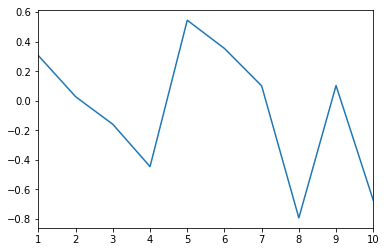

In [833]:
plot.df.head(10).apply(pct_change,axis=1).plot()

In [845]:
!pwd

/home/xbno/course-v3/code/course-v3-me/nbs/dl1


In [849]:
# import dill

# with open('180m_plot.p', 'wb') as handle:
#     dill.dump(plot, handle, protocol=dill.HIGHEST_PROTOCOL)

## Generate data in batches

In [6]:
def create_pct_change_mins(bar=2,bars_ahead=13):
    top_range = bar*bars_ahead
    return bar,[i for i in range(bar,top_range,bar)]

In [7]:
bar,pct_change_mins = create_pct_change_mins(bar=15,bars_ahead=13)

In [8]:
pct_change_mins

[15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]

In [9]:
window = 192

In [10]:
plot = PlotStockData('USDT_ETH',180,f'{bar}m',pct_change_mins,'/Users/xbno/ML/finviz_scrape/plot/data',window,1)

dur: 180 day(s)
bars: 17261
min: 2018-11-24 03:58:37 EST
max: 2019-05-22 23:45:00 EST
label counts:
15m_hold           16886
15m_buy              186
15m_sell             181
15m_strong_sell        5
15m_strong_buy         2
                       1
Name: 15m_buy_hold_sell_label, dtype: int64

label counts:
30m_hold           13830
30m_sell            1273
30m_buy             1250
30m_strong_buy       479
30m_strong_sell      427
                       2
Name: 30m_buy_hold_sell_label, dtype: int64

label counts:
45m_hold           12367
45m_buy             1594
45m_sell            1563
45m_strong_buy       897
45m_strong_sell      837
                       3
Name: 45m_buy_hold_sell_label, dtype: int64

label counts:
60m_hold           11319
60m_buy             1787
60m_sell            1738
60m_strong_buy      1249
60m_strong_sell     1164
                       4
Name: 60m_buy_hold_sell_label, dtype: int64

label counts:
75m_hold           10529
75m_buy             1937
75m_sell      

/home/xbno/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
remove_cols = (['date','image']+
               [c for c in plot.df.columns if 'buy_hold_sell' in c]+
               [c for c in plot.df.columns if 'up_down' in c]+
               [c for c in plot.df.columns if 'pos' in c]+
               [c for c in plot.df.columns if 'neg' in c]+
               [c for c in plot.df.columns if c in [f'{i}m_pct_change' for i in pct_change_mins]])
input_cols = [c for c in plot.df.columns if c not in remove_cols]

In [626]:
#input_cols = ['open','close','high','low']

In [12]:
pct_change_cols = [f'{i}m_pct_change' for i in pct_change_mins]

In [18]:
def train_val_test_idxs(plot,test_size=0,window=192,val_pct=.35):
    "Take window into account because it shortens the test size by 192 or window size"
    if test_size < 1: test_size = int(plot.df.shape[0]*test_size)
    print(test_size)
    train_idx = [i for i in range(0,plot.df.shape[0]-int(plot.df.shape[0]*val_pct)-window)]
#     val_idx = [i for i in range(plot.df.shape[0]-int(plot.df.shape[0]*val_pct)-window,plot.df.shape[0]-test_size-window)]
    val_idx = [i for i in range(plot.df.shape[0]-int(plot.df.shape[0]*val_pct),plot.df.shape[0]-test_size-window)] # adds cushion between train/val
    if test_size == 0:
        test_idx = []
    else:
        test_idx = [i for i in range(plot.df.shape[0]-test_size-window,plot.df.shape[0]-window)]
    print(f'train: {len(train_idx)}: {min(train_idx)} to {max(train_idx)}')
    print(f'valid: {len(val_idx)}: {min(val_idx)} to {max(val_idx)}')
    print(f'test: {len(test_idx)}: {min(test_idx)} to {max(test_idx)}')
    print(f'{plot.df.shape[0]-window*2} == {len(train_idx)+len(val_idx)+len(test_idx)}') # multiply window x2 becasue cushion now
    return train_idx, val_idx, test_idx

In [14]:
def correct_labels(plot,pct_change_cols,window):
    plot.df[pct_change_cols] = plot.df[pct_change_cols].shift(-window)
#     plot.df.dropna(inplace=True)
    return plot.df.dropna()

In [855]:
# plot.df = correct_labels(plot,pct_change_cols,window)

In [15]:
plot.trim()

dur: 180 day(s)
bars: 17247
min: 2018-11-24 04:15:00 EST
max: 2019-05-22 20:45:00 EST


In [16]:
plot.window

192

In [1859]:
plot.window = 192
window = 192

In [19]:
plot.gen_idx()
train_idx, val_idx, test_idx = train_val_test_idxs(plot,test_size=.1,window=window,val_pct=.25)

1724
train: 12744: 0 to 12743
valid: 2395: 12936 to 15330
test: 1724: 15331 to 17054
16863 == 16863


## Normalization

Modified normalization functions for the inputs, taken from fastai data.py

Would it be better to normalize per batch instead? And use batching in order?


In [20]:
import pandas as pd

In [21]:
def add_rolling_mean_std(plot):
    mean_std_df = plot.df[input_cols].rolling(96).agg([np.mean,np.std])
    mean_std_df.columns = ['_'.join([str(i) for i in t]) if t[1] != '' else t[0] for t in mean_std_df.columns]
    plot.df = pd.concat([plot.df,mean_std_df],axis=1)

In [22]:
len(train_idx)+len(val_idx)

15139

In [23]:
def normalize(x:TensorImage, mean:FloatTensor,std:FloatTensor)->TensorImage:
    "Normalize `x` with `mean` and `std`."
    return (x-mean) / std
#     return (x-mean[None,...]) / std[None,...]
#     return (x-mean[...,None,None]) / std[...,None,None] # the Nones must be for images

def denormalize(x:TensorImage, mean:FloatTensor,std:FloatTensor)->TensorImage:
    "Denormalize `x` with `mean` and `std`."
    return x*std + mean
#     return x*std[...,None,None] + mean[...,None,None]

def _normalize_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor, do_y:bool=False)->Tuple[Tensor,Tensor]:
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    x,y = b
    print(x)
    print(x.shape)
    mean,std = mean.to(x.device),std.to(x.device)
    x = normalize(x,mean,std)
    if do_y: y = normalize(y,mean,std)
    return x,y

def normalize_funcs(mean:FloatTensor, std:FloatTensor)->Tuple[Callable,Callable]:
    "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`."
    mean,std = tensor(mean),tensor(std)
    return (partial(_normalize_batch, mean=mean, std=std),
            partial(denormalize,      mean=mean, std=std))

def p_b(b):
    x,y = b
#     print(x.shape)
    return x.permute(0,2,1),y

def t_b(b):
    x,y = b
#     print(x.shape)
    return x.transpose_(2,1),y

# tv_mean = torch.Tensor(plot.df.iloc[train_idx+val_idx][input_cols].mean().values)
# tv_std = torch.Tensor(plot.df.iloc[train_idx+val_idx][input_cols].std().values)
tv_mean = torch.Tensor(plot.df.iloc[train_idx][input_cols].mean().values)
tv_std = torch.Tensor(plot.df.iloc[train_idx][input_cols].std().values)
tv_mean = tv_mean.view(tv_mean.shape[0],-1)
tv_std = tv_std.view(tv_std.shape[0],-1)

norm_b,denorm_b = normalize_funcs(tv_mean,tv_std)

In [24]:
def norm_per_b(b:Tuple[Tensor,Tensor], do_y:bool=False)->Tuple[Tensor,Tensor]:
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    x,y = b
    mean = x.mean(dim=0)
    std = x.std(dim=0)
    mean,std = mean.to(x.device),std.to(x.device)
    x = normalize(x,mean,std)
    if do_y: y = normalize(y,mean,std)
    return x,y

In [26]:
plot.idx[-1]

(17054, 17246)

In [120]:
bs = 64
data = (StockSigList
#             .from_df(plot.df[input_cols],path='.',cols=input_cols, idx=plot.idx)
            .from_df(plot.df.copy(),path='.',cols=input_cols,idx=plot.idx)
#             .split_by_idx(train_idx)
            .split_by_idxs(train_idx,val_idx)
            .label_from_df(cols=pct_change_cols,label_cls=FloatList)
#             .databunch(bs=bs,tfms=[norm_b]) #,t_b]) # conv
#             .databunch(bs=bs,tfms=[norm_b,t_b],drop_last=True) # lstm
            .databunch(bs=bs,tfms=[norm_per_b,t_b],drop_last=True) # lstm
#             .normalize()
       )

tdata = (StockSigList
            .from_df(plot.df.copy(),path='.',cols=input_cols,idx=plot.idx)
            .split_by_idx(test_idx)
#             .label_empty()
            .label_from_df(cols=pct_change_cols,label_cls=FloatList)
#             .databunch(bs=bs,tfms=[norm_b]) #,t_b]) # conv
#             .databunch(bs=bs,tfms=[norm_b,t_b],drop_last=True) # lstm
            .databunch(bs=bs,tfms=[norm_per_b,t_b],drop_last=True) # lstm
#             .normalize()
        )

data.test_dl = tdata.valid_dl

(17054, 17246)
(17247, 108)
(17054, 17246)
(17247, 108)


## Confirm labeling is correct

Labeled by taking open - close / close. This should be changed to close - next_close

    def pct_change(self,row):
        "Apply % change between bars"
        if row['open'] > row['close']:
            inc = row['open'] - row['close']
            pct_inc = (inc / row['close']) * 100
            return pct_inc
        else:
            dec = row['close'] - row['open']
            pct_dec = dec / row['close'] * 100
            return -pct_dec
            
    self.df[f'{m}_pct_change'] = pd.concat([self.df[self.open].shift(-i),self.df[self.close]],axis=1).apply(self.pct_change,axis=1)

In [37]:
plot.df[['close','open']+pct_change_cols].head()

,close,open,15m_pct_change,30m_pct_change,45m_pct_change,60m_pct_change,75m_pct_change,90m_pct_change,105m_pct_change,120m_pct_change,135m_pct_change,150m_pct_change,165m_pct_change,180m_pct_change
2,125.019997,125.019997,-0.494484,-0.750569,0.518403,-0.063676,0.351945,-0.472269,-0.948687,-0.759951,-1.231800,-1.554418,-1.264362,-1.615739
3,124.401794,124.401794,-0.257358,1.017920,0.432949,0.850635,0.022325,-0.456460,-0.266786,-0.740981,-1.065202,-0.773705,-1.126827,-0.524672
4,125.158585,124.081635,0.407098,-0.174336,0.240825,-0.582477,-1.058368,-0.869841,-1.341168,-1.663428,-1.373693,-1.724681,-1.126167,-0.941675
5,124.940392,125.668106,-0.000000,0.415886,-0.408853,-0.885575,-0.696719,-1.168869,-1.491692,-1.201452,-1.553053,-0.953493,-0.768679,-0.472850
6,124.940392,124.940392,0.415886,-0.408853,-0.885575,-0.696719,-1.168869,-1.491692,-1.201452,-1.553053,-0.953493,-0.768679,-0.472850,-0.392499


In [41]:
def pct_change(row):
    "Apply % change between bars"
    if row['next_close'] > row['close']:
        inc = row['next_close'] - row['close']
        pct_inc = (inc / row['close']) * 100
        return pct_inc
    else:
        dec = row['close'] - row['next_close']
        pct_dec = dec / row['close'] * 100
        return -pct_dec

In [87]:
close_df = plot.df[['close']].copy()

In [76]:
next_close_df = pd.concat([plot.df['close'],plot.df['close'].shift(-1)],axis=1)
next_close_df.columns = ['close','next_close']

In [77]:
next_close_df.head()

,close,next_close
2,125.019997,124.401794
3,124.401794,125.158585
4,125.158585,124.940392
5,124.940392,124.940392
6,124.940392,124.605278


In [46]:
(125.019997 - 124.401794) / 125.019997

0.004944832945404792

In [88]:
for i,pct_change_col in enumerate(pct_change_cols):
    if i == 4: break
    print(f'{-(i+1)}',pct_change_col)
    next_close_df = pd.concat([close_df['close'],close_df['close'].shift(-(i+1))],axis=1)
    next_close_df.columns = ['close','next_close']
    close_df[pct_change_col] = next_close_df.apply(pct_change,axis=1)

-1 15m_pct_change
-2 30m_pct_change
-3 45m_pct_change
-4 60m_pct_change


In [89]:
next_close_df.head()

,close,next_close
2,125.019997,124.940392
3,124.401794,124.605278
4,125.158585,123.250000
5,124.940392,124.069908
6,124.940392,123.480003


In [90]:
close_df.head()

,close,15m_pct_change,30m_pct_change,45m_pct_change,60m_pct_change
2,125.019997,-0.494483,0.110853,-0.063674,-0.063674
3,124.401794,0.608343,0.432950,0.432950,0.163570
4,125.158585,-0.174333,-0.174333,-0.442084,-1.524933
5,124.940392,-0.000000,-0.268219,-1.352958,-0.696719
6,124.940392,-0.268219,-1.352958,-0.696719,-1.168868


In [91]:
(125.019997 * (-0.494483/100)) + 125.019997

124.40179436823449

In [92]:
def future_from_pct_change(row,pct_change_col):
    return (row['close'] * (row[pct_change_col] / 100)) + row['close']

In [93]:
ffpc = partial(future_from_pct_change,pct_change_col='15m_pct_change')

In [97]:
close_df['close_shift_-1'] = close_df.apply(ffpc,axis=1)

In [99]:
for i,pct_change_col in enumerate(pct_change_cols):
    if i == 4: break
    print(f'{-(i+1)}',pct_change_col)
    ffpc = partial(future_from_pct_change,pct_change_col=pct_change_col)
    close_df[f'close_shift_{-(i+1)}'] = close_df.apply(ffpc,axis=1)

-1 15m_pct_change
-2 30m_pct_change
-3 45m_pct_change
-4 60m_pct_change


In [106]:
pd.concat([close_df['close_shift_-4'],close_df['close'].shift(-4)],axis=1).tail(10)

,close_shift_-4,close
17239,245.015182,245.015182
17240,244.531097,244.531097
17241,244.000000,244.000000
17242,241.491821,241.491821
17243,243.341568,243.341568
17244,243.358993,243.358994
17245,NaN,NaN
17246,NaN,NaN
17247,NaN,NaN
17248,NaN,NaN


## Reapply plot.df with new pct_change

In [107]:
plot.df.shape

(17247, 108)

In [109]:
plot.df = plot.df.drop(pct_change_cols,axis=1)

In [110]:
for i,pct_change_col in enumerate(pct_change_cols):
#     if i == 4: break
    print(f'{-(i+1)}',pct_change_col)
    next_close_df = pd.concat([plot.df['close'],plot.df['close'].shift(-(i+1))],axis=1)
    next_close_df.columns = ['close','next_close']
    plot.df[pct_change_col] = next_close_df.apply(pct_change,axis=1)

-1 15m_pct_change
-2 30m_pct_change
-3 45m_pct_change
-4 60m_pct_change
-5 75m_pct_change
-6 90m_pct_change
-7 105m_pct_change
-8 120m_pct_change
-9 135m_pct_change
-10 150m_pct_change
-11 165m_pct_change
-12 180m_pct_change


## Future plotting

Huge difference between iloc and loc.

    iloc does from start to (not including) end
    loc does from start to (including) end

In [114]:
non_shifted = plot.df.copy()

In [201]:
non_shifted.reset_index(drop=True,inplace=True)

In [202]:
non_shifted.iloc[window_start:window_end].shape

(192, 108)

In [203]:
val_idx[0]

12936

In [204]:
plot.idx[val_idx[0]]

(12936, 13128)

In [205]:
window_start = plot.idx[val_idx[0]][0]
window_end = plot.idx[val_idx[0]][-1]
non_shifted.iloc[window_start:window_end].head(1)

,date,close,high,low,open,quotevolume,volume,weightedaverage,pos_pct_change_0.0025,pos_pct_change_0.005,...,45m_pct_change,60m_pct_change,75m_pct_change,90m_pct_change,105m_pct_change,120m_pct_change,135m_pct_change,150m_pct_change,165m_pct_change,180m_pct_change
12936,2019-04-07 23:15:00,181.440094,181.849731,180.849503,181.250305,34.795456,6308.354004,181.298203,3.0,3.0,...,0.30859,0.260553,0.584163,0.975809,0.346947,0.249906,0.18928,0.472565,0.414705,-0.088581


In [206]:
non_shifted.iloc[window_start:window_end].tail(1)

,date,close,high,low,open,quotevolume,volume,weightedaverage,pos_pct_change_0.0025,pos_pct_change_0.005,...,45m_pct_change,60m_pct_change,75m_pct_change,90m_pct_change,105m_pct_change,120m_pct_change,135m_pct_change,150m_pct_change,165m_pct_change,180m_pct_change
13127,2019-04-09 23:00:00,179.048248,179.415329,179.0,179.0,24.894228,4458.89209,179.113495,-1.0,10.0,...,-0.64794,-0.321695,-0.318073,0.09077,-0.09313,-0.151115,0.057363,0.308162,0.528587,0.97278


In [207]:
future_window_start = plot.idx[val_idx[0]][-1]
future_window_end = plot.idx[val_idx[0]][-1] + len(pct_change_cols)

In [208]:
non_shifted.iloc[future_window_start:future_window_end].shape

(12, 108)

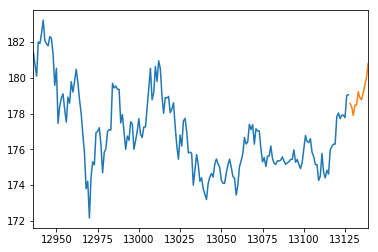

In [209]:
non_shifted.iloc[window_start:window_end]['close'].plot()
non_shifted.iloc[future_window_start:future_window_end]['close'].plot()

In [210]:
non_shifted.iloc[window_start:future_window_end]['close'].shape[0]

204

In [211]:
assert non_shifted.iloc[window_start:future_window_end]['close'].shape[0] == window+len(pct_change_cols)

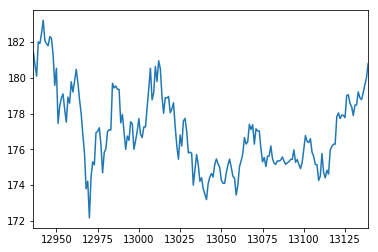

In [212]:
non_shifted.iloc[window_start:future_window_end]['close'].plot()

In [213]:
pd.DataFrame(non_shifted.iloc[window_end]).T[['close','15m_pct_change']]

,close,15m_pct_change
13128,178.57,-0.102352


In [164]:
def future_from_pct_change(row,pct_change_cols):
    return (row['close'] * (row[pct_change_cols] / 100)) + row['close']

In [214]:
ffpc = partial(future_from_pct_change,pct_change_cols=pct_change_cols)

In [216]:
pd.DataFrame(non_shifted.iloc[window_end+1]).apply(ffpc) # change this to +1-window when shifted ***

,13129
15m_pct_change,177.888
30m_pct_change,178.472
45m_pct_change,178.479
60m_pct_change,179.211
75m_pct_change,178.882
90m_pct_change,178.778
105m_pct_change,179.151
120m_pct_change,179.6
135m_pct_change,179.995
150m_pct_change,180.79


In [221]:
future_close_df = pd.DataFrame(non_shifted.iloc[window_end]).apply(ffpc)

In [182]:
#pd.DataFrame(non_shifted.iloc[window_end+1])

In [223]:
future_idx = [i for i in range(window_end,(window_end+len(pct_change_cols)))] # add two because this is iloc not the index

In [224]:
future_close_df.index = future_idx
future_close_df.columns = ['close']

In [227]:
future_close_df

,close
13128,178.387
13129,177.888
13130,178.472
13131,178.479
13132,179.211
13133,178.882
13134,178.778
13135,179.151
13136,179.6
13137,179.995


In [233]:
non_shifted.iloc[window_start:window_end][['close']].tail()

,close
13123,177.910965
13124,177.902161
13125,177.771667
13126,179.000000
13127,179.048248


In [236]:
eval_future_df = pd.concat([non_shifted.iloc[window_start:window_end][['close']],future_close_df])

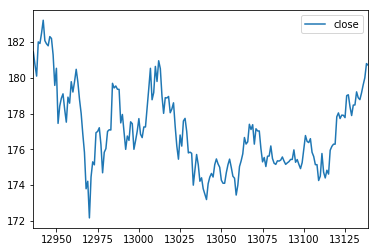

In [237]:
eval_future_df.plot()

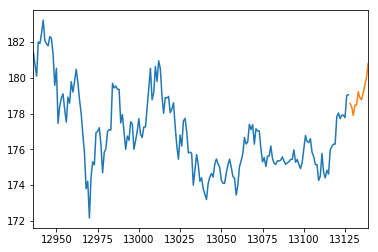

In [238]:
non_shifted.iloc[window_start:window_end]['close'].plot()
non_shifted.iloc[future_window_start:future_window_end]['close'].plot()

## Wrap this all up into a single function, include testing for shifted version of data

Base all inference off of
    
    data.valid_ds.x.items[0] and val_idx

In [144]:
print(window_start,window_end)
print(future_window_start,future_window_end)

12936 13128
13128 13140


In [149]:
non_shifted.iloc[window_start:window_end]['close'].tail()

13125    177.910965
13126    177.902161
13127    177.771667
13128    179.000000
13129    179.048248
Name: close, dtype: float32

In [143]:
non_shifted.iloc[future_window_start:future_window_end]['close'].head()

13130    178.570007
13131    178.387238
13132    177.888123
13133    178.472260
13134    178.478745
Name: close, dtype: float32

In [28]:
data.valid_ds.x.items[0]

array([[181.4401  , 181.84973 , 180.8495  , 181.2503  , ...,   1.427587,  58.80684 ,   1.280499,   2.065927],
       [180.7202  , 181.40938 , 180.58186 , 181.04208 , ...,   1.264206,  55.834408,   0.858235,   1.979663],
       [180.0902  , 181.01    , 179.      , 180.6301  , ...,   1.139685,  53.264156,   2.01    ,   1.98183 ],
       [182.      , 182.09694 , 180.      , 180.      , ...,   1.465417,  59.438904,   2.096943,   1.990052],
       ...,
       [177.90216 , 178.18184 , 177.90216 , 177.90984 , ...,   2.011573,  66.79476 ,   0.279685,   0.612327],
       [177.77167 , 177.99963 , 177.77167 , 177.99963 , ...,   1.853598,  64.95652 ,   0.227962,   0.584872],
       [179.      , 179.      , 178.71259 , 178.71259 , ...,   2.66009 ,  72.67827 ,   1.22833 ,   0.630834],
       [179.04825 , 179.41533 , 179.      , 179.      , ...,   2.694648,  72.93382 ,   0.415325,   0.61544 ]],
      dtype=float32)

In [1200]:
data.valid_dl.dl.dataset.y.items[0]

array([ 0.150958,  0.456879,  0.830799,  0.774797,  0.569321,  0.774797,  0.774797,  0.695777,  0.707666,  0.976849,
        1.268836, -3.18826 , -2.527906, -1.987253, -2.004973, -2.084711], dtype=float32)

In [1335]:
data.inner_df.shape

(2674, 120)

In [1135]:
data.inner_df.shape

(3238, 120)

In [1126]:
data.inner_df.iloc[data.plot_idx[-1][0]:data.plot_idx[-1][1]]

,date,close,high,low,open,quotevolume,volume,weightedaverage,15m_pct_change,30m_pct_change,...,close_13_sma,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,tr,atr,image


In [1136]:
tdata.inner_df.shape

(4095, 120)

In [1094]:
len(train_idx)

3238

In [1095]:
max(train_idx)

3237

In [1097]:
max(val_idx)

4094

In [1093]:
len(data.idx)

4095

In [1112]:
data.inner_df.shape

(857, 120)

In [1201]:
plot.df.iloc[-5:]

,date,close,high,low,open,quotevolume,volume,weightedaverage,15m_pct_change,30m_pct_change,...,close_13_sma,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,tr,atr,image
4092,2019-05-15 18:30:00,241.039993,242.039902,240.787552,242.039902,91.006180,21916.554688,240.824890,0.094978,-0.318988,...,240.068405,242.389999,-1.349999,1.183753,54.207275,1.208903,54.728661,1.602442,2.233776,2019-05-15T18-30-00_usdt_eth.jpeg
4093,2019-05-15 18:45:00,245.529999,245.746552,242.000000,242.000000,245.896255,60212.933594,244.871292,0.168520,1.324178,...,240.364075,241.039993,4.489999,2.549392,71.826164,1.837199,64.753975,4.706545,2.410403,2019-05-15T18-45-00_usdt_eth.jpeg
4094,2019-05-15 19:00:00,247.430405,247.850006,245.449997,245.746552,739.115234,182828.968750,247.361908,0.347677,0.261209,...,240.812561,245.529999,1.900400,3.243003,76.431786,2.127302,68.023560,2.399999,2.409659,2019-05-15T19-00-00_usdt_eth.jpeg
4095,2019-05-15 19:15:00,248.392746,249.736542,246.620499,247.848999,327.883057,81392.171875,248.235367,-0.018336,1.151782,...,241.486938,247.430405,0.962349,3.664491,78.561432,2.287563,69.582336,3.116040,2.460115,2019-05-15T19-15-00_usdt_eth.jpeg
4096,2019-05-15 19:30:00,248.369995,248.656097,246.669998,247.520203,68.295410,16902.048828,247.484406,0.079201,0.981909,...,242.236923,248.392746,-0.022749,3.621195,78.360573,2.278148,69.494972,1.986095,2.426257,2019-05-15T19-30-00_usdt_eth.jpeg


In [2442]:
it = iter(data.test_dl)
# it = iter(data.valid_dl)
# it = iter(data.train_dl)

for x,y in it:
    print(x.shape)

torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])
torch.Size([64, 192, 28])


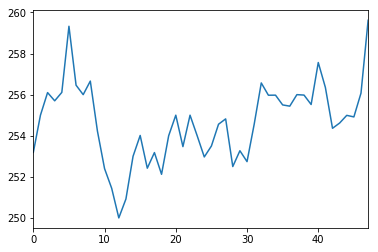

In [52]:
pd.DataFrame(data.test_ds.x.items[-1])[0].plot()

In [56]:
one_batch = data.one_batch()

In [57]:
one_batch[0].shape

torch.Size([64, 48, 28])

In [58]:
one_batch[1].shape

torch.Size([64, 4])

## Potentially Normalize per batch with Std

In [176]:
from sklearn.preprocessing import StandardScaler

In [177]:
std = StandardScaler()
x = std.fit_transform(plot.df[input_cols]).astype(np.float32)

/home/xbno/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/xbno/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [186]:
std.partial_fit(plot.df[input_cols].iloc[2:4])

/home/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


StandardScaler(copy=True, with_mean=True, with_std=True)

In [187]:
std.mean_

array([1.705485e+02, 1.709114e+02, 1.701674e+02, 1.705446e+02, 6.157181e+01, 1.115869e+04, 1.705389e+02, 1.702647e+02,
       1.147849e+00, 1.702647e+02, 1.725604e+02, 1.679690e+02, 1.703836e+02, 1.701806e+02, 2.029737e-01, 1.992359e-01,
       7.475567e-03, 1.704876e+02, 1.704431e+02, 1.703687e+02, 1.705184e+02, 3.016987e-02, 1.432821e+00, 5.182116e+01,
       1.214880e+00, 5.178735e+01, 8.595028e-01, 8.442517e-01])

## Training: Conv1d

Try training a 1dConv using `nn.Conv_1d()`

In [364]:
from fastai import basic_train
import fastai

In [365]:
plot.window # timesteps

48

In [366]:
len(pct_change_cols) # output size

5

In [367]:
data.train_ds.y[0].data.shape # confirm output size

(5,)

In [327]:
data.train_ds.x

StockSigList (939 items)
(shape=torch.Size([48, 2])),(shape=torch.Size([48, 2])),(shape=torch.Size([48, 2])),(shape=torch.Size([48, 2])),(shape=torch.Size([48, 2]))
Path: .

In [27]:
# learn.loss_func = F.mse_loss
# learn.loss_func = F.l1_loss

## Conv1d

https://discuss.pytorch.org/t/understanding-convolution-1d-output-and-input/30764/5

    Signal shape: [32, 100, 1] == [batch_size, in_channels, len]
    
    Conv1d (
        Each kernel creates an output channel
        
    Check batch shape:
        
    

dur: 15 day(s)
bars: 1409
min: 2019-04-29 01:30:00 EST
max: 2019-05-13 17:30:00 EST


In [368]:
plot.df[input_cols].shape

(2858, 2)

In [369]:
plot.df[input_cols].replace(np.inf,np.nan).dropna().shape

(2858, 2)

In [32]:
def conv1d_layer(ni:int, nf:int, ks:int=3, stride:int=1)->nn.Sequential:
    "Create Conv2d->BatchNorm2d->LeakyReLu layer: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride."
    return nn.Sequential(
        nn.Conv1d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm1d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

In [49]:
ks = 17
m = nn.Sequential(
        nn.Conv1d(in_channels=192, #plot.window,
                  out_channels=16,
                  kernel_size=ks,
                  stride=1,
                  padding=ks//2,
                  bias=False),
#         nn.AvgPool1d(kernel_size=2,
#                      stride=2)
        nn.Linear(16,14)
)

In [40]:
one_batch = data.one_batch()

In [36]:
inp = torch.rand(64,4,192)

In [395]:
m = nn.Sequential(conv1d_layer(48,1,12),
                  conv1d_layer(48,1,12)
                  )

In [39]:
m(inp).shape

torch.Size([64, 1, 193])

In [637]:
m(inp).shape

torch.Size([1, 48, 5])

In [444]:
learn = basic_train.Learner(data=data,
                            model=m,
                            loss_func=F.l1_loss)

In [373]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.303755,0.515339,00:01
1,0.291928,0.499972,00:01
2,0.285517,0.496524,00:01
3,0.283641,0.494270,00:01
4,0.282486,0.496684,00:01


## test ground for ins and outs

conv input and output channels are usualy always the same, except for the first layer that bumps 3channel in to 64 in resent

helpful stuff:
https://jhui.github.io/2018/02/09/PyTorch-Basic-operations/

In [576]:
data.batch_size = 64

In [90]:
batch = data.one_batch()
batch[0].shape

torch.Size([64, 4, 192])

In [92]:
batch[1].shape

torch.Size([64, 5])

In [124]:
pad = nn.ReflectionPad1d(1)

In [135]:
pad(one_batch[0]).shape

torch.Size([64, 4, 194])

In [1528]:
one_batch[0].shape

torch.Size([64, 192, 28])

In [341]:
import torch
from torch import nn

# (batch_size,in_channels,time_steps) says guy on forum

def conv1d_layer(ni:int, nf:int, ks:int=3, stride:int=1)->nn.Sequential:
    "Create Conv2d->BatchNorm2d->LeakyReLu layer: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride."
    return nn.Sequential(
        nn.Conv1d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm1d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

w = 192
channel_in = len(input_cols)
ks = 49
targs_out = 16
bs = 64

inp = torch.ones(bs,w,channel_in)

In [1539]:
cv_batch = cvdata.one_batch()

In [1540]:
cv_batch[0].shape

torch.Size([64, 28, 192])

In [1533]:
inp.shape

torch.Size([64, 192, 28])

In [1543]:
import torch
from torch import nn

a = torch.randn(32, 28, 192)  
m = nn.Conv1d(28, 64, 3, padding=3//2) 
out = m(a)
print(out.size())
print(m)

torch.Size([32, 64, 192])
Conv1d(28, 64, kernel_size=(3,), stride=(1,), padding=(1,))


In [1544]:
m = conv1d_layer(28,64,3)

In [ ]:
m = nn.Sequential()
m

In [1546]:
m(a).shape

torch.Size([32, 64, 192])

In [1537]:
m = nn.Sequential(nn.Linear(w,targs_out))

In [1538]:
m(inp)

RuntimeError: size mismatch, m1: [12288 x 28], m2: [192 x 16] at /opt/conda/conda-bld/pytorch_1550802451070/work/aten/src/TH/generic/THTensorMath.cpp:940

In [1529]:
m = nn.Sequential(
# linear for kicks
#                     nn.Linear(channel_in,512),
#                     nn.Linear(512,256),
#                     nn.Linear(256,1),
# rando 43.9
#                   nn.Conv1d(channel_in, 64, kernel_size=ks, padding=ks//2),
#                   nn.Conv1d(64, 64, kernel_size=ks, padding=ks//2),
#                   nn.Conv1d(64, 128, kernel_size=ks, padding=ks//2),
#                   nn.Conv1d(128, 128, kernel_size=ks, padding=ks//2),
#                   nn.Conv1d(128, 1, kernel_size=ks, padding=ks//2),
# #                   nn.AdaptiveAvgPool1d(5), # 43.9
#                   nn.Linear(timeframe,targs_out) # 43.5
# new ks
                  nn.Conv1d(channel_in, 64, kernel_size=15, padding=15//2),
                  nn.ReLU(inplace=True),
                  nn.Conv1d(64, 64, kernel_size=7, padding=7//2),
                  nn.ReLU(inplace=True),
                  nn.Conv1d(64, 128, kernel_size=3, padding=3//2),
                  nn.ReLU(inplace=True),
                  nn.Conv1d(128, 128, kernel_size=3, padding=3//2),
                  nn.ReLU(inplace=True),
                  nn.Conv1d(128, 1, kernel_size=3, padding=3//2),
                  nn.ReLU(inplace=True),
#                   nn.AdaptiveAvgPool1d(5), # 43.9
                  nn.Linear(w,targs_out) # 43.5
# next 43.4
#                   nn.Conv1d(channel_in, 64, kernel_size=ks, padding=ks//2),
#                   nn.Conv1d(64, 128, kernel_size=ks, padding=ks//2),
#                   nn.Linear(192,28),
#                   nn.Conv1d(128, 1, kernel_size=ks, padding=ks//2),
#                   nn.Linear(28,targs_out)
# reflection padding
#                   nn.ReflectionPad1d(ks//2),
#                   nn.Conv1d(channel_in, 128, kernel_size=ks),#, padding=ks//2),
#                   nn.ReflectionPad1d(ks//2),
#                   nn.Conv1d(128, 1, kernel_size=ks),#, padding=ks//2),
#                   nn.Conv1d(50, 1, kernel_size=ks, padding=ks//2),
#                   nn.Conv1d(12, 6, ks, padding=ks//2),
#                   nn.Conv1d(6, 1, ks, padding=ks//2),
#                   nn.Linear(48,5)
#                   nn.AdaptiveAvgPool1d(1),
#                   nn.AdaptiveMaxPool1d(1),
#                   Flatten()
# with conv1d layer 43.4
#                     conv1d_layer(ni=channel_in,nf=64,ks=3),
#                     conv1d_layer(ni=64,nf=128,ks=3),
#                     conv1d_layer(ni=128,nf=256,ks=3),
#                     conv1d_layer(ni=256,nf=512,ks=3),
#                     conv1d_layer(ni=512,nf=1024,ks=3),
#                     conv1d_layer(ni=1024,nf=128,ks=3),
#                     conv1d_layer(ni=128,nf=1,ks=3),
# #                     nn.AdaptiveAvgPool1d(targs_out)
#                     nn.Linear(192,targs_out)
                    
                    
                 )
out = m(inp)

RuntimeError: Given groups=1, weight of size [64, 28, 15], expected input[64, 192, 28] to have 28 channels, but got 192 channels instead

In [615]:
inp.shape

torch.Size([64, 28, 192])

In [616]:
one_batch[0].shape

torch.Size([64, 192, 28])

In [613]:
out.shape

torch.Size([64, 1, 15])

In [142]:
nis = [64,128,1]
kss = [15,7,3]

modules = []
modules.append(conv1d_layer(ni=channel_in,nf=nis[0],ks=kss[0]))

for i,(ni,ks) in enumerate(zip(nis,kss)):
    if i+1 == len(nis): break
    print(ni,nis[i+1])
    modules.append(conv1d_layer(ni,nis[i+1],ks))
    
modules.append(nn.Linear(192,targs_out))

m = nn.Sequential(*modules)

64 128
128 1


In [ ]:
out = m(inp)
out.shape

In [1]:
1

1

In [56]:
cv = conv1d_layer(28,14,5)

In [1568]:
cv = nn.Sequential(
    conv1d_layer(192,64,17),
    conv1d_layer(64,64,3),
#     conv1d_layer(64,64,3),
    conv1d_layer(64,64,3),
    nn.v(64),
#     nn.AdaptiveAvgPool2d(1),
#     nn.BatchNorm1d(64),
#     nn.ReLU(),
#     nn.Linear(28,16)
                  )

In [1582]:
cv_batch[0].shape

torch.Size([64, 28, 192])

In [1601]:
class ModelCV(nn.Module):
    def __init__(self,ni,no,bs,w,nh=3):
        super().__init__()
        self.nh = nh

        self.cv1 = conv1d_layer(ni,64,ks)
        self.cv2 = conv1d_layer(64,64,ks)
        self.cv3 = conv1d_layer(64,64,ks)
        self.bn1 = nn.BatchNorm1d(w*64)
        self.l1 = nn.Linear(w*64,64)
        self.bn2 = nn.BatchNorm1d(64)
        self.l2 = nn.Linear(64,no)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        res = self.cv1(x)
        res = self.cv2(res)
        res = self.cv3(res)
        res = res.view(x.shape[0],-1)
        res = self.bn1(res)
        res = self.relu(res)
        res = self.l1(res)
        res = self.bn2(res)
        res = self.relu(res)
        res = self.l2(res)
        return res

inp = torch.rand(64,28,192)
cv = ModelCV(ni=28,no=16,bs=64,w=192)
cv(inp).shape

## lstm cells and lstm

In [462]:
class Lstm(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [1477]:
class Model5(nn.Module):
    def __init__(self,ni,no,bs,w,nh=3,nl=3):
        self.nl = nl
        self.nh = nh
        
        super().__init__()
        self.gru = nn.GRU(input_size=ni,
               hidden_size=nh,
               num_layers=nl,
               batch_first=True,
               dropout=.9)
        self.relu = nn.ReLU()
        self.h_o = nn.Linear(w*nh,no)
        self.cv1 = conv1d_layer(w,1,33)
#         self.cv2 = conv1d_layer(16,1,7)
        self.l_o = nn.Linear(nh,no)
        self.h = torch.zeros(self.nl, bs, self.nh).cuda()
        
    def forward(self, x):
        res,h = self.gru(x, self.h)
        self.h = h.detach()
#         print(res.shape)
        res = self.relu(res)
        res = self.h_o(res.contiguous().view(x.shape[0],-1))
#         res = self.cv1(res)
#         res = self.cv2(res)
#         print('cv',res.shape)
#         res = self.l_o(res)
#         print(res.shape)
        return res

In [1498]:
class Model6(nn.Module):
    def __init__(self,ni,no,bs,w,nh=3,nl=3):
        self.nl = nl
        self.nh = nh
        self.bs = bs
        
        super().__init__()
        self.gru = nn.GRU(input_size=ni,
               hidden_size=nh,
               num_layers=nl,
               batch_first=True,
               dropout=.5)
        self.cv1 = conv1d_layer(w,nh,3)
        self.cv2 = conv1d_layer(nh,1,3)
        self.cvo = conv1d_layer(w,1,7)
        self.h_o = nn.Linear(w*nh,nh)
        self.h2_o = nn.Linear(nh,no)
        self.l_o = nn.Linear(nh,no)
        self.h = torch.zeros(self.nl, bs, self.nh).cuda()
        self.relu = nn.ReLU()
        self.bn = BatchNorm1dFlat(nh)
        
    def forward(self, x):
        res,h = self.gru(x, self.h)
        self.h = h.detach()
        res = self.bn(res)
#         print(res.shape)
# hiddens
#         res = self.h_o(res.contiguous().view(self.bs,-1))
#         res = self.h2_o(res)
# restype
        res = self.cvo(res)
#         res = self.cv1(res)
#         print(res.shape)
#         res = self.cv2(res)
#         print('cv',res.shape)
        res = self.l_o(res)
#         print(res.shape)
        return res

In [2441]:
class Model9(nn.Module):
    def __init__(self,ni,no,bs,w,nh=3,nl=3):
        self.nl = nl
        self.nh = nh
        self.bs = bs
        
        super().__init__()
        self.gru = nn.GRU(input_size=ni,
               hidden_size=nh,
               num_layers=nl,
               batch_first=True,
               dropout=.5)
        self.cv1 = conv1d_layer(w,nh,15)
        self.cv2 = conv1d_layer(nh,64,7)
        self.adp = nn.AdaptiveAvgPool2d(1)
        self.cvo = conv1d_layer(w,1,3)
        self.h_o = nn.Linear(w*nh,nh)
        self.h2_o = nn.Linear(nh,no)
        self.l_o = nn.Linear(nh,no)
        self.h = torch.zeros(self.nl, bs, self.nh).cuda()
        self.relu = nn.ReLU()
        self.bn = BatchNorm1dFlat(nh)
        
    def forward(self, x):
        res,h = self.gru(x, self.h)
        self.h = h.detach()
        res = self.bn(res)
#         print(res.shape)
# hiddens
#         res = self.h_o(res.contiguous().view(self.bs,-1))
#         res = self.h2_o(res)
# restype
#         res = self.cvo(res)
        res = self.cv1(res)
#         print(res.shape)
        res = self.cv2(res)
        res = self.adp(res)
#         print('cv',res.shape)
#         res = self.bn(res)
        res = self.relu(res)
        res = self.l_o(res)
#         print(res.shape)
        return res

In [959]:
class Model7(nn.Module):
    def __init__(self,ni,no,bs,w,nh,lnh=50,nl=3):
        self.nl = nl
        self.nh = nh
        self.bs = bs
        self.h = torch.zeros(self.nl, bs, self.nh).cuda()
        
        super().__init__()
        self.gru = nn.GRU(input_size=ni,
               hidden_size=nh,
               num_layers=nl,
               batch_first=True,
               dropout=.5)

        self.l_o = lin_o(w*nh,lnh,no,w)
        self.bn = BatchNorm1dFlat(nh)
        
    def forward(self, x):
        res,h = self.gru(x, self.h)
        self.h = h.detach()
        res = self.bn(res)
        res = self.l_o(res.contiguous().view(self.bs,-1))
        return res

def lin_o(ni,nh,no,w)->nn.Sequential:
    "Create Conv2d->BatchNorm2d->LeakyReLu layer: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride."
    return nn.Sequential(
        nn.Linear(ni,nh),
        nn.BatchNorm1d(nh),
        nn.LeakyReLU(negative_slope=0.1, inplace=True),
#         nn.ReLU(inplace=True),
        nn.Linear(nh,no))

In [1938]:
class Model8(nn.Module):
    def __init__(self,ni,no,bs,w,nh=3,nl=3):
        self.nl = nl
        self.nh = nh
        self.bs = bs
        self.h = torch.zeros(self.nl, bs, self.nh).cuda()
        
        super().__init__()
        self.gru = nn.GRU(input_size=ni,
               hidden_size=nh,
               num_layers=nl,
               batch_first=True,
               dropout=.5)
        
        self.bn = BatchNorm1dFlat(nh)
        self.l1 = lin(nh*w,nh)
        self.l2 = lin(nh,nh)
        self.lo = lino(nh,100,no)
        
    def forward(self, x):
        res,h = self.gru(x, self.h)
        self.h = h.detach()
#         print(res.shape)
        res = self.bn(res)
#         print(res.shape)
        res = self.l1(res.contiguous().view(self.bs,-1))
#         print(res.shape)
        res = self.l2(res)
        res = self.lo(res)
        return res

def lin(ni,nh)->nn.Sequential:
    "Create Conv2d->BatchNorm2d->LeakyReLu layer: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride."
    return nn.Sequential(
        nn.Linear(ni,nh),
        nn.BatchNorm1d(nh),
#         nn.LeakyReLU(negative_slope=-0.1, inplace=True),
        nn.ReLU(inplace=True))
    
def lino(ni,nh,no)->nn.Sequential:
    "Create Conv2d->BatchNorm2d->LeakyReLu layer: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride."
    return nn.Sequential(
        nn.Linear(ni,nh),
        nn.BatchNorm1d(nh),
#         nn.LeakyReLU(negative_slope=-0.1, inplace=True),
        nn.ReLU(inplace=True),
        nn.Linear(nh,no))



In [2052]:
# m = Model5(ni=28,nh=12,nl=3,no=16,bs=64,w=192) # low 43s 42.5s
# m = Model6(ni=28,nh=24,nl=2,no=16,bs=64,w=192) # not good
# m = Model7(ni=28,nh=24,nl=2,no=5,bs=64,w=192) # looking decent keep this
# m = Model7(ni=28,nh=500,lnh=500,nl=2,no=len(pct_change_cols),bs=bs,w=window) # simple gru
# m = Model8(ni=28,nh=500,nl=3,no=len(pct_change_cols),bs=bs,w=window) # looking decent keep this
m = Model8(ni=28,nh=500,nl=3,no=len(pct_change_cols),bs=bs,w=window) # almost too good, found issue with data it seems?
# m = Model8(ni=28,nh=250,nl=3,no=len(pct_change_cols),bs=bs,w=window) # preformed decently 42loss with equal1 and 50 with w192

In [1935]:
inp = torch.rand(64,192,28)

In [1936]:
m(inp).shape

torch.Size([64, 12])

In [866]:
one_batch = data.one_batch()

In [867]:
one_batch[0].shape

torch.Size([128, 48, 28])

In [47]:
from fastai import basic_train
import fastai

In [342]:
class ModelCV(nn.Module):
    def __init__(self,ni,no,ks,bs,w,nh=3):
        super().__init__()
        self.nh = nh

        self.cv1 = conv1d_layer(ni,64,ks)
        self.cv2 = conv1d_layer(64,128,ks)
        self.cv3 = conv1d_layer(128,256,ks)
        self.bn1 = nn.BatchNorm1d(w*256)
        self.l1 = nn.Linear(w*256,256)
        self.bn2 = nn.BatchNorm1d(256)
        self.l2 = nn.Linear(256,no)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        res = self.cv1(x)
        res = self.cv2(res)
        res = self.cv3(res)
        res = res.view(x.shape[0],-1)
        res = self.bn1(res)
        res = self.relu(res)
        res = self.l1(res)
        res = self.bn2(res)
        res = self.relu(res)
        res = self.l2(res)
        return res

inp = torch.rand(64,28,192)
cv = ModelCV(ni=28,no=16,ks=3,bs=64,w=192)
cv(inp).shape

torch.Size([64, 16])

In [559]:
def lin(ni,nh)->nn.Sequential:
    "Create Conv2d->BatchNorm2d->LeakyReLu layer: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride."
    return nn.Sequential(
        nn.Linear(ni,nh),
        nn.BatchNorm1d(nh),
#         nn.LeakyReLU(negative_slope=-0.1, inplace=True),
        nn.ReLU(inplace=True))

In [1548]:
class ModelL(nn.Module):
    def __init__(self,ni,no,nh,bs,w):
        super().__init__()
        self.bs = bs
        self.flatten = Flatten()
        self.l1 = lin(ni*w,nh)
        self.l2 = lin(nh,nh)
        self.l3 = lin(nh,nh)
        self.l4 = lin(nh,nh)
        self.l5 = lin(nh,nh)
        self.lo = nn.Linear(nh,no)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        res = self.flatten(x.contiguous())
#         print(x.shape)
        res = self.l1(res)
        res = self.l2(res)
        res = self.l3(res)
        res = self.l4(res)
        res = self.l5(res)
        res = self.lo(res)
        return res

inp = torch.rand(bs,28,window)
l = ModelL(ni=28,nh=2000,no=len(pct_change_cols),bs=bs,w=window)
l(inp).shape

torch.Size([128, 12])

In [566]:
inp.shape

torch.Size([64, 4, 48])

In [545]:
one_batch[0].shape

torch.Size([64, 48, 28])

In [549]:
f = Flatten()
f(one_batch[0]).shape

torch.Size([64, 1344])

In [1868]:
def get_min_max_of_float_targs(plot,targs,cushion=2):
    print(f'max: {plot.df.iloc[train_idx][targs].max().max()}')
    print(f'min: {plot.df.iloc[train_idx][targs].min().min()}')
    max = plot.df.iloc[train_idx][targs].max().max()
    min = plot.df.iloc[train_idx][targs].min().min()
#     return min-cushion,max+cushion
    return min/2,max/2

minmax = get_min_max_of_float_targs(plot,pct_change_cols)

max: 17.088838577270508
min: -15.577637672424316


In [1869]:
minmax

(-7.788818836212158, 8.544419288635254)

In [870]:
from fastai import basic_train
import fastai

In [1870]:
class mse_custom(nn.Module):
    def __init__(self,weight,order):
        super().__init__()
        self.w = weight
        self.order = torch.Tensor(order)
        
    def forward(self, preds, target, reduction='mean'):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        abs_losses = torch.abs(preds - target)**2
        if reduction == 'mean':
            return torch.mean(abs_losses*(torch.abs(target)*self.w)*self.order.cuda())
        else:
            return abs_losses*(torch.abs(target)*self.w)*self.order

class signed_loss(nn.Module):
    def __init__(self,weight,order):
        super().__init__()
        self.w = weight
        self.order = torch.Tensor(order)
        
    def forward(self, preds, target, reduction='mean'):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        signed_loss = torch.abs(torch.abs(preds.sign()+target.sign())-2)
        if reduction == 'mean':
            return torch.mean(torch.mean(signed_loss*self.order.cuda()*(torch.abs(target)*self.w)))
        else:
            return signed_loss*self.order*(torch.abs(target)*self.w)

class slope_loss(nn.Module):
    def __init__(self,weight,order):
        super().__init__()
        self.w = weight
        self.order = torch.Tensor(order)
        
    def forward(self, preds, target, reduction='mean'):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        slope_target = (self.order*target.cpu()).mean(dim=1)
        slope_preds = (self.order*preds.cpu()).mean(dim=1)
        signed_loss = torch.abs(torch.abs(slope_preds.sign()+slope_target.sign())-2)
        if reduction == 'mean':
            return torch.mean(signed_loss*(torch.abs(target)*self.w).mean(dim=1).cpu())
        else:
            return signed_loss*(torch.abs(target)*self.w)

In [384]:
preds = torch.rand(16,4)-.5
target = torch.rand(16,4)-.5

In [437]:
target.mean(dim=1)

tensor([-0.2634,  0.0370,  0.2688, -0.0356,  0.0097, -0.1761,  0.1008,  0.0308,
         0.1219,  0.0858,  0.1171,  0.1740,  0.2132,  0.0037, -0.2895, -0.0122])

In [1345]:
equal = [i+1 for i in range(len(pct_change_cols))]
# equal = equal[::-1]
equal = [1 for i in range(len(pct_change_cols))]

In [2049]:
equal = np.linspace(1,2,len(pct_change_cols))

In [1672]:
equal = [0,0,0,0,0,0,0,0,1,1,1,1]

In [2050]:
mse = mse_custom(50,equal)

In [1673]:
signed = signed_loss(50,equal)

In [1663]:
slope = slope_loss(50,equal)

In [304]:
#torch.rand(64,4)*torch.Tensor([4,3,2,1])

In [2053]:
data.batch_size = bs
learn = basic_train.Learner(data=data,
                            model=m,
#                             loss_func=F.mse_loss,
#                             loss_func=F.l1_loss,
                            loss_func=mse,
#                             loss_func=signed,
#                             loss_func=slope
                           )
learn.model.add_module('sig_range',fastai.layers.SigmoidRange(*minmax))
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,254.574692,126.358688,00:48
1,197.636108,155.115158,00:48
2,126.887634,107.485672,00:48
3,99.809174,66.547600,00:48
4,70.169006,69.471222,00:48


In [2054]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,87.149002,69.921547,00:47
1,106.571640,140.717682,00:48
2,120.572807,140.726135,00:47
3,103.688210,96.469208,00:48
4,90.123413,59.489620,00:48
5,80.645523,68.810570,00:48
6,71.595627,84.752220,00:48
7,59.287952,74.443260,00:48
8,48.930851,74.146896,00:48
9,46.891026,71.430176,00:48


In [2448]:
learn.path = Path('/home/xbno/ml/finviz_scrape/')

In [2446]:
learn.path = 

PosixPath('.')

In [2450]:
learn.save('good_180d')

valid pred min val: -7.090921401977539
valid pred max val: 7.425135612487793
valid targ min val: -9.019136428833008
valid targ max val: 12.574454307556152


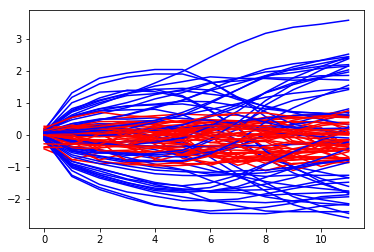

In [2055]:
test_preds = learn.get_preds(ds_type=DatasetType.Test)
eval_preds(test_preds)

t = np.arange(len(pct_change_cols))
i=0
for preds,truths in zip(*test_preds):
    plt.plot(t,np.array(preds),color='blue')
    plt.plot(t,np.array(truths),color='red')
    i += 1
    if i > 50: break

valid pred min val: -6.640963077545166
valid pred max val: 7.591312885284424
valid targ min val: -7.315088748931885
valid targ max val: 6.916091442108154


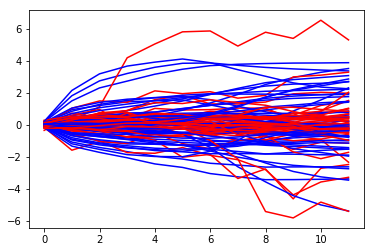

In [2056]:
ri = list(np.random.randint(1,len(val_idx),50))

test_preds = learn.get_preds(ds_type=DatasetType.Valid)
eval_preds(test_preds)

t = np.arange(len(pct_change_cols))
i = 1
for preds,truths in zip(*test_preds):
    if i in ri:        
        plt.plot(t,np.array(preds),color='blue')
        plt.plot(t,np.array(truths),color='red')
    else:
        pass
    i += 1

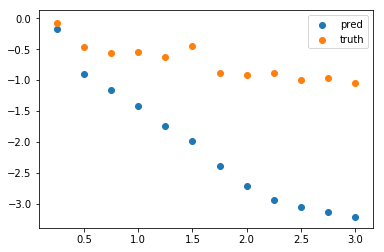

In [2081]:
t = [i/60 for i in pct_change_mins]
ri = np.random.choice(test_preds[0].shape[0])
plt.scatter(t,np.array(test_preds[0][ri]))
plt.scatter(t,np.array(test_preds[1][ri]))
plt.legend(['pred','truth'])

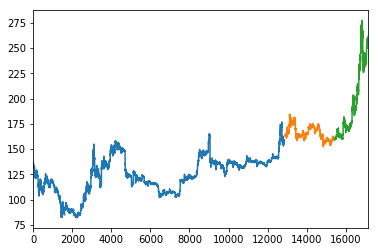

In [1127]:
plot.df['open'].iloc[train_idx].plot()
plot.df['open'].iloc[val_idx].plot()
plot.df['open'].iloc[test_idx].plot()

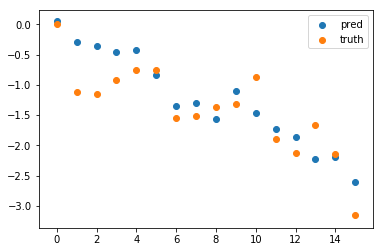

In [983]:
# ri = np.random.choice(test_preds[0].shape[0])
plt.scatter(t,np.array(test_preds[0][-1]))
plt.scatter(t,np.array(test_preds[1][-1]))
plt.legend(['pred','truth'])

## Interpret Losses

In [2082]:
valid_pred,valid_targ,valid_loss = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_preds = (valid_pred,valid_targ)

num=20
lowest_val_loss = pd.DataFrame(np.array(valid_loss.mean(dim=1))).sort_values(0).index.tolist()[:num]
highest_val_loss = pd.DataFrame(np.array(valid_loss.mean(dim=1))).sort_values(0,ascending=False).index.tolist()[:num]

In [2083]:
loss_df = pd.concat([pd.DataFrame(np.array(valid_loss.mean(dim=1)),columns=['loss']),
    pd.DataFrame(np.array(valid_loss),columns=[f'loss_{i}' for i in pct_change_mins]),
    pd.DataFrame(np.array(valid_pred),columns=[f'pred_{i}' for i in pct_change_mins]),
    pd.DataFrame(np.array(valid_targ),columns=[f'targ_{i}' for i in pct_change_mins])],axis=1)

In [2084]:
loss_df = loss_df.sort_values(by='loss')

In [2085]:
loss_min_cols = [f'loss_{i}' for i in pct_change_mins]

In [2086]:
m = 45
loss_df[[f'pred_{m}',f'targ_{m}']].describe()

,pred_45,targ_45
count,2368.000000,2368.000000
mean,-0.005977,0.008167
std,0.998569,0.529375
min,-4.126950,-4.604517
25%,-0.555301,-0.225124
50%,0.016055,0.006308
75%,0.544797,0.272739
max,3.611037,4.098434


In [2087]:
loss_df[loss_min_cols].describe()

,loss_15,loss_30,loss_45,loss_60,loss_75,loss_90,loss_105,loss_120,loss_135,loss_150,loss_165,loss_180
count,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000
mean,0.329085,8.285049,17.247601,26.458672,37.082401,48.181114,62.027554,79.641098,103.013779,127.419937,155.395065,192.897095
std,0.986988,32.686028,53.155209,75.345169,98.088211,122.600357,153.571396,194.788361,238.659760,282.609161,356.965790,448.285492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006
25%,0.000447,0.179076,0.359260,0.670305,0.897248,1.102269,1.673616,2.257323,3.239261,4.260519,5.514338,6.986773
50%,0.017793,1.333215,2.585077,3.708790,5.384714,7.454701,11.213652,15.941902,22.605553,27.324624,33.158777,40.952097
75%,0.187030,5.817182,12.041176,18.575016,26.618690,38.290840,54.297208,68.542593,95.097158,116.549877,136.394173,166.114208
max,15.339581,904.681091,1209.866943,1471.107910,1610.635498,1625.556641,1859.269531,2971.569824,3108.106201,3349.606934,6020.827637,5634.984863


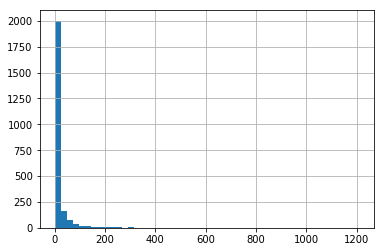

In [2088]:
loss_df[f'loss_{m}'].hist(bins=50)

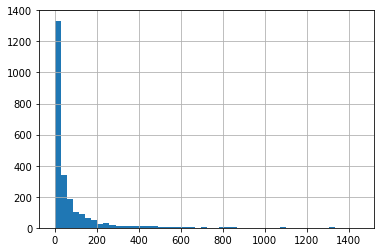

In [2089]:
loss_df['loss'].hist(bins=50)

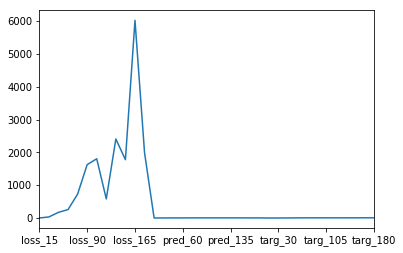

In [2090]:
loss_df.drop('loss',axis=1).iloc[-1].plot()

In [ ]:
learn.data.

In [ ]:
def interp_loss(learn,num=20,test_type=DatasetType.Valid):
    valid_pred,valid_targ,valid_loss = learn.get_preds(ds_type=test_type,with_loss=True)
    valid_preds = (valid_pred,valid_targ)
    
    lowest_val_loss = pd.DataFrame(np.array(valid_loss.mean(dim=1))).sort_values(0).index.tolist()[:num]
    highest_val_loss = pd.DataFrame(np.array(valid_loss.mean(dim=1))).sort_values(0,ascending=False).index.tolist()[:num]
    
    
    t = [i/60 for i in pct_change_mins]
    ri = np.random.choice(lowest_val_loss)
    print(ri)
    plt.scatter(t,np.array(valid_preds[0][ri]))
    plt.scatter(t,np.array(valid_preds[1][ri]))
    plt.legend(['pred','truth'])

    pred_times = pd.Series([i for i in range(window,window+len(pct_change_cols))])

    last_price = pd.DataFrame(learn.data.valid_ds.x.items[ri])[0].iloc[-1]
    print(last_price)
    pred_dollar_value = pd.Series([((i/100)*last_price)+last_price for i in np.array(valid_preds[0][ri])])
    pred_dollar_value.name = 'pred_open'

    truth_dollar_value = pd.Series([((i/100)*last_price)+last_price for i in np.array(valid_preds[1][ri])])
    truth_dollar_value.name = 'open'

    preds = pd.concat([truth_dollar_value,pred_dollar_value],axis=1)

    preds.index = pred_times

    example = pd.DataFrame(data.valid_ds.x.items[ri])[0]
    example.name = 'open'
    example = pd.DataFrame(example)

    pd.concat([example,preds]).plot()

In [2268]:
valid_pred,valid_targ,valid_loss = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
valid_preds = (valid_pred,valid_targ)

num=100
lowest_val_loss = pd.DataFrame(np.array(valid_loss.mean(dim=1))).sort_values(0).index.tolist()[:num]
highest_val_loss = pd.DataFrame(np.array(valid_loss.mean(dim=1))).sort_values(0,ascending=False).index.tolist()[:num]

In [2375]:
truth_dollar_value

0     194.720105
1     195.555813
2     195.089936
3     195.686706
4     196.341178
5     196.512960
6     196.542554
7     196.230421
8     196.710774
9     196.794273
10    199.019961
11    198.707827
Name: open, dtype: float64

In [2412]:
[i for i in np.array(valid_preds[0][ri])]

[-0.033481874,
 -0.19027364,
 -0.2775178,
 -0.3572024,
 -0.36610514,
 -0.44944245,
 -0.47687346,
 -0.51099586,
 -0.57572955,
 -0.6108729,
 -0.6703051,
 -0.73011]

In [2419]:
(plot.df['close'] == 202.99991).idxmax()

16573

In [2437]:
truth_end_idx = (plot.df['close'] == 202.99991).idxmax()
truth_end_idx = 16576
print(truth_end_idx)
pred_end_idx = truth_end_idx+12

16576


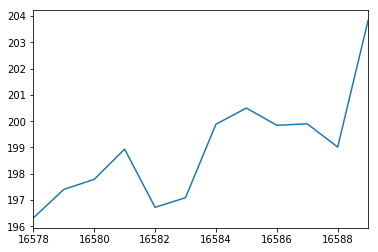

In [2438]:
plot.df.iloc[truth_end_idx:pred_end_idx]['close'].plot()

In [2423]:
pred_dollar_value

0     202.931940
1     202.613653
2     202.436548
3     202.274788
4     202.256715
5     202.087541
6     202.031856
7     201.962587
8     201.831178
9     201.759837
10    201.639190
11    201.517786
Name: pred_open, dtype: float64

In [2424]:
t

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]

In [2440]:
len(plot.idx)

17006

In [2439]:
plot.idx[ri]

(1093, 1285)

1093
202.99991


ValueError: Length mismatch: Expected axis has 24 elements, new values have 12 elements

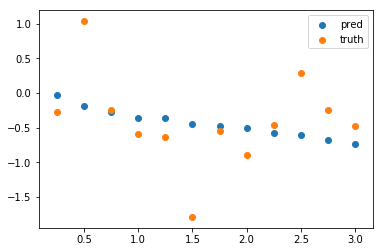

In [2422]:
t = [i/60 for i in pct_change_mins]
ri = np.random.choice(lowest_val_loss)
ri = 1093
print(ri)
plt.scatter(t,np.array(valid_preds[0][ri]))
plt.scatter(t,np.array(valid_preds[1][ri]))
plt.legend(['pred','truth'])

pred_times = pd.Series([i for i in range(window,window+len(pct_change_cols))])

last_price = pd.DataFrame(data.test_ds.x.items[ri])[0].iloc[-1]
print(last_price)
pred_dollar_value = pd.Series([((i/100)*last_price)+last_price for i in np.array(valid_preds[0][ri])])
pred_dollar_value.name = 'pred_open'

# truth_dollar_value = pd.Series([((i/100)*last_price)+last_price for i in np.array(valid_preds[1][ri])])
# truth_dollar_value.name = 'open'

truth_dollar_value = plot.df.iloc[truth_end_idx:pred_end_idx]['close']

preds = pd.concat([truth_dollar_value,pred_dollar_value],axis=1)

preds.index = pred_times

example = pd.DataFrame(data.test_ds.x.items[ri])[0]
example.name = 'open'
example = pd.DataFrame(example)

pd.concat([example,preds]).plot()

In [2378]:
1.02*199

202.98

In [2430]:
test_idx[ri]

16380

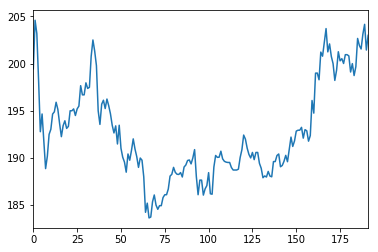

In [2428]:
pd.DataFrame(data.test_ds.x.items[ri])[0].plot()

In [2426]:
data.test_ds.x.items[ri][0]

array([ 1.994500e+02,  1.995000e+02,  1.974539e+02,  1.994900e+02,  7.574659e+02,  1.504947e+05,  1.986818e+02,
        1.963987e+02,  1.642323e+00,  1.963987e+02,  1.996833e+02,  1.931140e+02,  1.972451e+02,  1.953639e+02,
        1.881171e+00,  1.746306e+00,  2.697301e-01,  1.983230e+02,  1.973255e+02,  1.967851e+02,  1.998000e+02,
       -3.499993e-01,  2.380442e+00,  7.041808e+01,  1.826627e+00,  6.462215e+01,  2.346108e+00,  2.106291e+00],
      dtype=float32)

In [2204]:
test_idx[-1]

17005

1022
171.4


/home/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



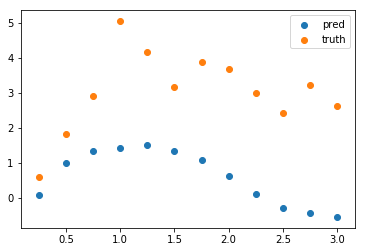

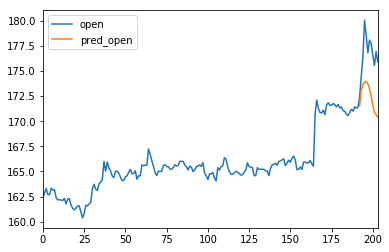

In [2257]:
t = [i/60 for i in pct_change_mins]
ri = np.random.choice(highest_val_loss)
# ri = 1663
print(ri)
plt.scatter(t,np.array(valid_preds[0][ri]))
plt.scatter(t,np.array(valid_preds[1][ri]))
plt.legend(['pred','truth'])

pred_times = pd.Series([i for i in range(window,window+len(pct_change_cols))])

last_price = pd.DataFrame(data.valid_ds.x.items[ri])[0].iloc[-1]
print(last_price)
pred_dollar_value = pd.Series([((i/100)*last_price)+last_price for i in np.array(valid_preds[0][ri])])
pred_dollar_value.name = 'pred_open'

truth_dollar_value = pd.Series([((i/100)*last_price)+last_price for i in np.array(valid_preds[1][ri])])
truth_dollar_value.name = 'open'

preds = pd.concat([truth_dollar_value,pred_dollar_value],axis=1)

preds.index = pred_times

example = pd.DataFrame(data.valid_ds.x.items[ri])[0]
example.name = 'open'
example = pd.DataFrame(example)

pd.concat([example,preds]).plot()

In [2221]:
pct_change_cols

['15m_pct_change',
 '30m_pct_change',
 '45m_pct_change',
 '60m_pct_change',
 '75m_pct_change',
 '90m_pct_change',
 '105m_pct_change',
 '120m_pct_change',
 '135m_pct_change',
 '150m_pct_change',
 '165m_pct_change',
 '180m_pct_change']

## These should be layed out sideways to see where

In [2258]:
data

StockSigBunch;

Train: LabelList (12707 items)
x: StockSigList
(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192]))
y: FloatList
[0.446489 0.578855 0.258889 0.197176 0.518521 1.373275 1.000512 0.572519 0.740458 1.082163 0.813164 0.572519],[ 0.017296 -0.300883 -0.362252 -0.042701  0.807281  0.436599  0.010996  0.177997  0.517794  0.250297  0.010996
 -0.127552],[-0.04629  -0.107816  0.212551  1.064703  0.693075  0.266385  0.433813  0.774478  0.506298  0.266385  0.127484
 -0.371339],[-0.        0.320713  1.173785  0.801755  0.374605  0.542213  0.883246  0.614776  0.374605  0.235554 -0.263808
 -2.36046 ],[-5.315947e-08  8.503450e-01  4.795047e-01  5.372000e-02  2.207927e-01  5.607347e-01  2.931236e-01  5.371992e-02
 -8.488675e-02 -5.826521e-01 -2.672601e+00 -2.572662e+00]
Path: .;

Valid: LabelList (2388 items)
x: StockSigList
(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=t

In [2264]:
tp = learn.get_preds(DatasetType.Test)
vp = learn.get_preds(DatasetType.Valid)
trp = learn.get_preds(DatasetType.Train)

In [2265]:
tp[0].shape

torch.Size([1664, 12])

In [2267]:
vp[0].shape

torch.Size([2368, 12])

In [2259]:
data.valid_ds

LabelList (2388 items)
x: StockSigList
(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192]))
y: FloatList
[-0.        0.196363  0.432588  0.609676  0.307847  0.207237  0.061924  0.020782 -0.129009  0.035622 -0.178129
 -0.295811],[ 0.196363  0.432588  0.609676  0.307847  0.207237  0.061924  0.020782 -0.129009  0.035622 -0.178129 -0.295811
 -0.355237],[ 0.131522  0.308079  0.007154 -0.093154 -0.238031 -0.279049 -0.428392 -0.264254 -0.477365 -0.594694 -0.653942
 -0.665341],[-0.157597 -0.457124 -0.556966 -0.701171 -0.741999 -0.890648 -0.727273 -0.939394 -1.056178 -1.115151 -1.126497
 -1.714761],[-0.1002   -0.200401 -0.345123 -0.386097 -0.535279 -0.371318 -0.5842   -0.701403 -0.760587 -0.771974 -1.362347
 -1.558157]
Path: .

In [2260]:
data.test_ds

LabelList (1719 items)
x: StockSigList
(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192])),(shape=torch.Size([28, 192]))
y: FloatList
[-0.08274  -0.048817 -0.048817  0.085723 -0.094278 -0.087327 -0.235657 -0.305918 -0.443568 -0.25315  -0.25315
 -0.689592],[ 0.155601  0.155601  0.290417  0.110048  0.117012 -0.03162  -0.102025 -0.239956 -0.049149 -0.049149 -0.486484
 -0.832405],[-0.        0.134606 -0.045483 -0.038529 -0.186931 -0.257227 -0.394943 -0.204432 -0.204432 -0.641088 -0.986471
 -0.757592],[ 0.0113   -0.168566 -0.161621 -0.30984  -0.380049 -0.517597 -0.32732  -0.32732  -0.763438 -1.108396 -0.879799
 -0.847309],[-0.179846 -0.172902 -0.321105 -0.391306 -0.528837 -0.338582 -0.338582 -0.774651 -1.11957  -0.890999 -0.858513
 -0.866729]
Path: .

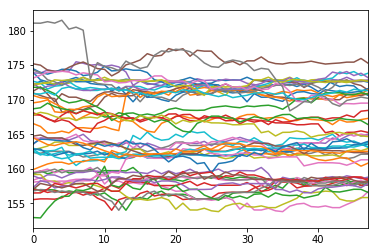

In [1647]:
for i in lowest_val_loss:
    pd.DataFrame(data.valid_ds.x.items[i])[0].plot()

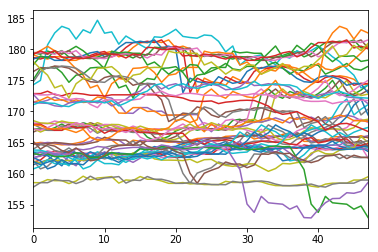

In [1646]:
for i in highest_val_loss:
    pd.DataFrame(data.valid_ds.x.items[i])[0].plot()

In [1003]:
from datetime import datetime,timedelta

In [ ]:
last_price = wdf['open'].iloc[-1]

In [1032]:
pred_times = pd.Series([plot.wdf['date'].iloc[-1]+timedelta(minutes=change_min) for change_min in pct_change_mins])
pred_times.name = 'date'

In [1018]:
valid_preds[0][-1]

tensor([ 0.0518, -0.3000, -0.3596, -0.4599, -0.4199, -0.8331, -1.3478, -1.3081,
        -1.5679, -1.1104, -1.4618, -1.7229, -1.8590, -2.2246, -2.1887, -2.6070])

In [1050]:
pred_dollar_value = pd.Series([((i/100)*last_price)+last_price for i in np.array(valid_preds[0][-1])])
pred_dollar_value.name = 'pred_open'

truth_dollar_value = pd.Series([((i/100)*last_price)+last_price for i in np.array(valid_preds[1][-1])])
truth_dollar_value.name = 'open'

preds = pd.concat([pred_times,truth_dollar_value,pred_dollar_value,],axis=1)

/home/xbno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


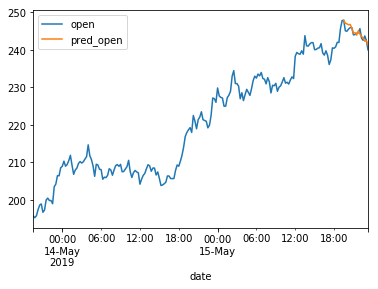

In [1054]:
pd.concat([wdf[['date','open']],preds]).set_index('date').plot()

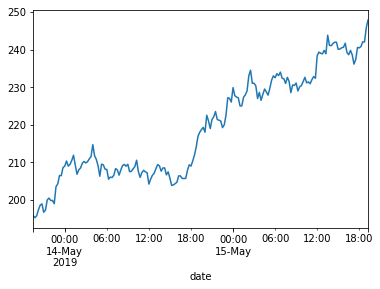

In [1045]:
wdf.set_index('date')['open'].plot()

In [1009]:
wdf['open'].iloc[-1]

247.849

In [1007]:
wdf = plot.wdf.copy()

In [ ]:
pd.concat()

In [974]:
val_idx[-1]

4094

In [980]:
last_idx = val_idx[-193],val_idx[-1]

In [981]:
plot.set_wdf(idx=last_idx)

In [955]:
test_preds = learn.get_preds(ds_type=DatasetType.Valid)
eval_preds(test_preds)


valid pred min val: -5.697587490081787
valid pred max val: 6.693675518035889
valid targ min val: -7.196676254272461
valid targ max val: 8.71981430053711


In [75]:
def eval_preds(valid_preds):
    print(f'valid pred min val: {valid_preds[0].min()}')
    print(f'valid pred max val: {valid_preds[0].max()}')
    print(f'valid targ min val: {valid_preds[1].min()}')
    print(f'valid targ max val: {valid_preds[1].max()}')

In [966]:
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
eval_preds(valid_preds)

valid pred min val: -5.697587490081787
valid pred max val: 6.693675518035889
valid targ min val: -7.196676254272461
valid targ max val: 8.71981430053711


## try learner with it

In [103]:
from fastai import basic_train

## kernel 2d

always keep kernel size equal on both sides with the padding the same to have the same dims in the output

kernels always have to be odd numbers to have the ks//2 work for padding

keep this stuff for layering symbols

In [534]:
inp = torch.ones(1, 2, 48, 2)
c = nn.Conv1d(2, 2, kernel_size=[5,5], padding=2) # makes sense if I'm stacking multiple symbols on top of another

In [535]:
c.weight.data

tensor([[[[-0.1095, -0.0136, -0.1313,  0.1190, -0.0314],
          [ 0.0621, -0.0714, -0.0578, -0.0474, -0.0040],
          [-0.0043, -0.0923,  0.1355,  0.1095, -0.0577],
          [ 0.0491,  0.0883, -0.0034, -0.1038,  0.0236],
          [ 0.0696, -0.0182,  0.1019, -0.1118, -0.0337]],

         [[-0.1021,  0.0224, -0.0118,  0.0277, -0.0898],
          [ 0.0692,  0.0624,  0.1124,  0.0500, -0.0415],
          [-0.0746, -0.0013,  0.1187, -0.0865,  0.0368],
          [-0.0244, -0.0222,  0.1055, -0.0629, -0.0116],
          [ 0.0338, -0.1393,  0.1084, -0.0267,  0.0735]]],


        [[[ 0.0802,  0.1140,  0.0485, -0.0181,  0.1225],
          [ 0.0716, -0.0113, -0.0943,  0.1214,  0.0588],
          [ 0.0085, -0.1245, -0.1039,  0.0385,  0.0656],
          [-0.0295, -0.0598,  0.0875,  0.0514,  0.1304],
          [-0.1199,  0.1208,  0.1181,  0.1346,  0.1338]],

         [[ 0.0773,  0.1324,  0.0260,  0.0373, -0.0757],
          [-0.1135,  0.0127,  0.0601,  0.1403,  0.1197],
          [-0.0220,  0.

In [536]:
c(inp).shape

torch.Size([1, 2, 48, 2])

## kernel 1d

In [540]:
inp = torch.ones(1, 2, 48)
c = nn.Conv1d(2, 2, kernel_size=5, padding=2)

In [541]:
c.weight.data

tensor([[[ 0.3045,  0.1065,  0.1519, -0.3045,  0.0191],
         [ 0.2904, -0.2493,  0.2351,  0.2683, -0.2036]],

        [[-0.1130, -0.3081, -0.1750, -0.1934,  0.2789],
         [-0.0974,  0.2299, -0.0848,  0.0470, -0.2820]]])

In [542]:
c(inp).shape

torch.Size([1, 2, 48])

In [490]:
out

tensor([[[ 1.0050,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,
           1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,
           1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,
           1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,
           1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,
           1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  1.1749,
           1.1749,  1.1749,  1.1749,  1.1749,  1.1749,  0.6896],
         [-0.4588, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100,
          -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100,
          -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100,
          -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100,
          -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100,
          -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3100,
          -0.3100, -0.3100, -0.3100, -0.3100, -0.3100, -0.3

### If labeling continuous

Help the model pred between -15% and +15% by appending a sigmoid layer at end

Change loss_func to mse or l1

Unfreeze model also

In [724]:
pct_change_cols = [c for c in labels.columns if 'pct_change' in c]
print(labels[pct_change_cols].min())

15m_pct_change     -1.312737
30m_pct_change    -11.731647
45m_pct_change    -12.406398
60m_pct_change    -12.630493
90m_pct_change    -13.942370
120m_pct_change   -14.053929
150m_pct_change   -14.755344
180m_pct_change   -15.577637
240m_pct_change   -15.847681
dtype: float64

In [725]:
labels[pct_change_cols].max()

15m_pct_change      1.344172
30m_pct_change      7.180885
45m_pct_change     12.910304
60m_pct_change     13.277480
90m_pct_change     15.175653
120m_pct_change    14.820099
150m_pct_change    15.303919
180m_pct_change    16.424160
240m_pct_change    15.868945
dtype: float64

In [23]:
import fastai

In [24]:
learn.model.add_module('sig_range',fastai.layers.SigmoidRange(-20,20))

In [25]:
learn.loss_func = F.mse_loss

In [675]:
learn.unfreeze()

In [624]:
# learn.summary()

In [740]:
learn.loss_func

<function torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='mean')>

### If labeling multi cat

In [671]:
learn.model.add_module('sig_range',fastai.layers.SigmoidRange(0,1))

### Train

In [26]:
# ran 5 and did get better than .7val and .51 acc
# ran 20 more to get into the .000s
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,28.315731,2.687375,01:10
1,2.888556,0.924084,01:10
2,2.072497,1.002901,01:10
3,1.755039,0.961519,01:10
4,1.482153,0.922306,01:10


In [28]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,1.823258,1.124059,01:10
1,1.743593,1.027941,01:10
2,1.380415,0.899188,01:10
3,1.184765,0.890190,01:10
4,1.049906,0.884276,01:10


In [711]:
learn.unfreeze()

In [712]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,1.209480,0.807638,01:05
1,1.806206,0.809860,01:04
2,1.641865,0.899749,01:04
3,1.365276,0.765126,01:04
4,1.205432,1.095428,01:04
5,0.981040,0.853904,01:05
6,0.795094,0.864700,01:05
7,0.637818,0.841543,01:05
8,0.471938,0.853860,01:04
9,0.461411,0.846237,01:05


## Predictions from a Model

https://forums.fast.ai/t/predicting-on-single-image-using-fastai-model/7869/15

Viewing and predicting a single image:

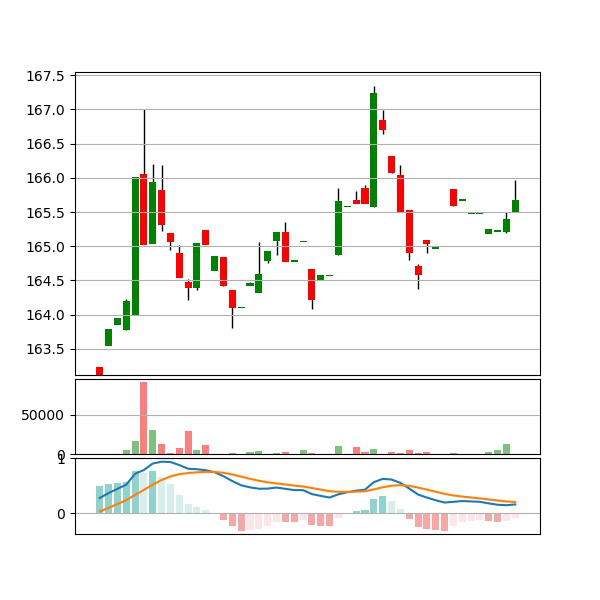

In [292]:
open_image(path/'2019-04-17T00-15-00_usdt_eth.jpeg')

In [48]:
learn.predict(open_image(path/'2019-04-17T00-15-00_usdt_eth.jpeg'))

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([ 0.0128,  0.0642,  0.1047,  0.0986,  0.0232, -0.0178, -0.0638, -0.0842,
         -0.1918]))

In [47]:
labels[labels['image'] == '2019-04-17T00-15-00_usdt_eth.jpeg'][pct_change_cols]

,15m_pct_change,30m_pct_change,45m_pct_change,60m_pct_change,90m_pct_change,120m_pct_change,150m_pct_change,180m_pct_change,240m_pct_change
16260,-0.184976,0.191677,0.157887,0.274915,0.051204,-0.189774,-0.324079,-0.037447,-0.055335


### Predict fresh data

For a batch, first create databunch batch, then select part of the databunch thats the test set and plug it into the model

In [825]:
plot_new = PlotStockData('USDT_ETH',3,'15m',[],'/Users/xbno/ML/finviz_scrape/plot/data',192,1)

dur: 3 day(s)
bars: 273
min: 2019-05-15 02:53:23 EST
max: 2019-05-17 22:45:00 EST


In [ ]:
def novel_batch(plot,input_cols,no):
    novel = torch.Tensor(plot.df.iloc[-192:][input_cols].values.T)
    

In [879]:
norm_b(zeroed_novel)

ValueError: too many values to unpack (expected 2)

In [826]:
plot.df.shape

(272, 72)

In [868]:
plot.df.iloc[-1]['open']

239.68962

In [835]:
novel = normalize(torch.Tensor(plot.df.iloc[-192:][input_cols].values.T),mean=tv_mean,std=tv_std)

In [886]:
novel = torch.Tensor(plot.df.iloc[-192:][input_cols].values.T).view(1,28,192)

In [888]:
zeros = torch.zeros(63,28,192)

In [895]:
zeroed_novel_x = torch.cat((zeros,novel))

In [900]:
zeroed_novel_batch = t_b(norm_b((zeroed_novel_x,zeroed_novel_y)))

In [901]:
novel_pred = learn.pred_batch(zeroed_novel_batch)

In [906]:
novel_pred[-1]

tensor([ 0.0200, -0.2987, -0.6389, -0.9566, -1.0406, -1.0164, -1.0667, -1.1568,
        -1.3265, -1.0613, -1.0698, -1.0187, -0.8824, -0.9252, -0.7745])

In [887]:
novel.shape

torch.Size([1, 28, 192])

In [839]:
one_batch[0].shape

torch.Size([64, 192, 28])

In [843]:
novel = novel.t().view(1,192,28)

In [847]:
zeros = torch.zeros(63,192,28)

In [850]:
zeroed_novel = torch.cat((zeros,novel),0)

In [855]:
zeroed_novel_y = torch.zeros(64,15)

In [857]:
novel_pred = learn.pred_batch((zeroed_novel,zeroed_novel_y))

In [864]:
novel_pred[-1]

tensor([-0.0376, -0.4861, -1.0195, -1.6839, -2.1686, -2.5458, -2.9878, -3.5585,
        -3.5103, -3.6659, -3.6215, -3.6677, -3.5545, -3.5804, -3.3995])

In [877]:
novel_real_price = [((i/100)*plot.df.iloc[-1]['open'])+plot.df.iloc[-1]['open'] for i in np.array(novel_pred[-1])]

Text(0.5, 1.0, '2019-05-17 22:45:00 EST')

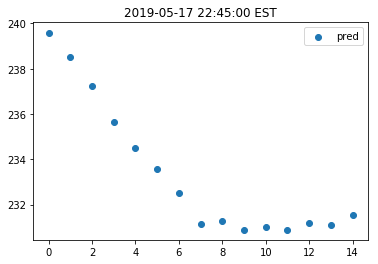

In [878]:
plt.scatter(t,novel_real_price)
# plt.scatter(t,np.array(novel_preds[-1]))
plt.legend(['pred','truth'])
plt.title('2019-05-17 22:45:00 EST')

### Using lear.get_preds

    returns a list of [preds,true_values]
    


In [49]:
# single btach pred
# test_preds = learn.pred_batch(test_db.valid_ds).numpy()

# full test set, but only uses the original dataset
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
test_preds = learn.get_preds(ds_type=DatasetType.Test)

In [55]:
def eval_preds(valid_preds):
    print(f'valid pred min val: {valid_preds[0].min()}')
    print(f'valid pred max val: {valid_preds[0].max()}')
    print(f'valid targ min val: {valid_preds[1].min()}')
    print(f'valid targ max val: {valid_preds[1].max()}')

In [377]:
def pred_direction(row,minutes=60):
    if row[f'{minutes}m_pct_change'] < 0 and row[f'{minutes}m_pct_change_pred'] < 0:
        return True
    else:
        return False